## Train Classifier
In this third experiment, we train a classifier that learns the policy of a DQN given by a replay data set created in experiment 2. We train a non-spiking and a spiking network for the classifier and then test the performance of both on the environment.

Experiment List:
1. DQN-Training (How to train a conventional DQN and a spiking DQN using Surrogate Gradients (DSQN).)
2. Load-DQN (How to load a previously saved D(S)QN and how to save a replay dataset.)
3. Train-Classifier (How to train a spiking or non-spiking classifier on the saved replay data set.)
4. SNN-Conversion (How to convert a DQN and a Classifier to a SNN.)
5. Load in NEST (How to load a converted or directly trained spiking network in NEST.)
6. Conversion in pyNN with NEST or SpyNNaker (How to load spiking network in pyNN using NEST or SpyNNaker as backend.)

In [1]:
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../../')
from Code import load_agent, train_classifier, SQN, FullyConnected

# set seeds
torch.manual_seed(1)
random.seed(1)
gym_seed = 1

# device: automatically runs on GPU, if a GPU is detected, else uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Detected PyNN version 0.9.5 and Neo version 0.6.1


We first create the result directory.

<div class="alert alert-block alert-warning">
<b>Attention:</b> If the directory with the specified name already exists, this will throw an error. You need to specify a different name or delete the old directory. If this happens, you should restart the kernel, as the directory is a relative path which changes everytime this cell is run.
</div>

In [2]:
# switch to the Result Directory
os.chdir('./../../Results/')
# choose the name of the result directory
result_directory = 'CartPole-Experiment3-Classifier'
# create the result directory (throws an error if the directory already exists)
os.makedirs(result_directory)
os.chdir(result_directory)
# create subdirectory for non spiking classifier
os.makedirs('Classifier')
os.chdir('Classifier')

Now we define the architecture of the Classifier, for which we simply choose the same architecture as the DQN. We then provide the path to the folder of the replay memory which should contain two files, memory_input.npz and memory_output.npz, set a few hyperparameters and start the training which uses the NLL-Loss function. Training can take a while, plot of the accuracy and loss over the last 100 batches is displayed every 1000 iterations.

current iteration:  199000


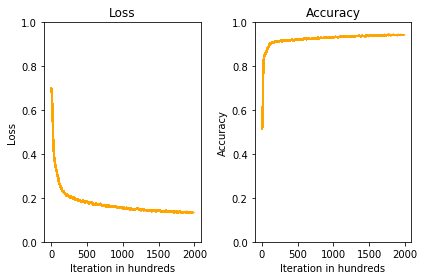

Loss:  tensor(0.1329, grad_fn=<DivBackward0>)
Accuracy:  0.9426000000000071


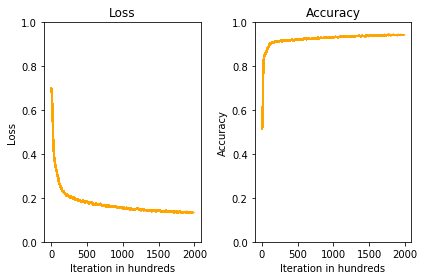

In [3]:
path_to_replay = ('./../../CartPole-A/DQN/trained')
# initialize classifier network, we choose the same architecture as of the original DQN, but potentially it could be different.
architecture = [4, 16, 16, 2]
classifier_network = FullyConnected(architecture).to(device)

# hyperparameters 
SPIKING = False #whether a spiking classifier should be trained
LEARNING_RATE = 0.0001
BATCH_SIZE = 50
NUMBER_OF_ITERATIONS = 2*10**5 #how many batches to train the classifier for

# start the training
train_classifier(classifier_network,spiking=SPIKING,learning_rate=LEARNING_RATE,path_to_replay=path_to_replay,device=device,
                 batch_size=BATCH_SIZE,iterations=NUMBER_OF_ITERATIONS)

We now immediately load the classifier to check its performance. Loading was elaborately explained in the last experiment. We load the weights of a classifier that were saved beforehand in the results. Of course we could also load the weights of the classifier we just trained, but we use the one whose results are reported in the thesis.

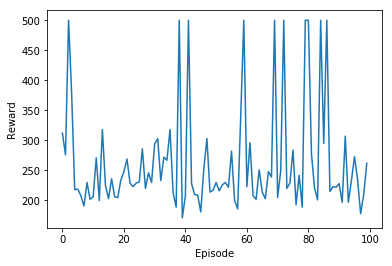

Complete
Mean:  262.35
Std:  88.01783278909387


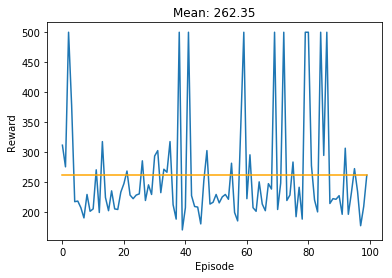

In [5]:
# define the environment
env = 'CartPole-v0'

# load weights
classifier = FullyConnected(architecture).to(device)
classifier.load_state_dict(torch.load('./../../CartPole-A/Classifier/trained/model.pt'))

# load the classifier
load_agent(env,classifier,device,epsilon=0,gym_seed=gym_seed,save_replay=False,max_steps=500,num_episodes=100, render=True)

Next, we train a classifier using a spiking neural network that learns the policy of the DQN. This is a novel approach to conversion of DQNs and is explained in our thesis (section 2.3.5, available in this repository). It works analogous to the training of a conventional classifier except that we use the class DSQN.

In [3]:
# make subdirectory for spiking classifier
os.makedirs('./../SNNClassifier')
os.chdir('./../SNNClassifier')

current iteration:  199000


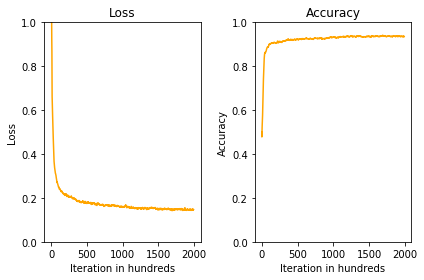

Loss:  tensor(0.1404)
Accuracy:  0.9392400000000055


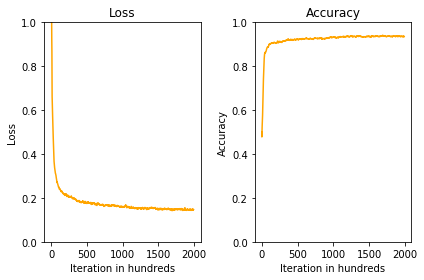

In [6]:
# initialize SNN classifier network, we choose the same architecture as of the original DSQN, but potentially it could be different.
architecture = [4, 17, 17, 2]
# initialize SQN hyperparameters
# first hyperparameters as for the non-spiking classifier
LEARNING_RATE = 0.0001
BATCH_SIZE = 50
NUMBER_OF_ITERATIONS = 2*10**5
path_to_replay = ('./../../CartPole-A/DQN/trained/Replay_Memory')
# SQN specific parameters
# We use a non-leaky integrate-and-fire neuron
ALPHA = 0
BETA = 1
# Simulation time is chosen relatively short, such that the network does not need too much time to run, but not too short,
# such that it can still learn something
SIMULATION_TIME = 20
# We also have to define the input/output and reset methods, to our knowledge, SpyTorch supports only potential outputs 
# and reset-by-subtraction. As input method we use constant input currents. It would be interesting to see if SpyTorch
# can also use reset-to-zero, as this would make it more similar to the iaf_delta models in NEST and SpyNNaker
ENCODING = 'constant'
DECODING = 'potential'
RESET = 'subtraction'
# SpyTorch uses a fixed threshold of one, we didn't test other thresholds, but should be possible
THRESHOLD = 1

# set up the classifier network
snn_classifier_network = SQN(architecture,device,alpha=ALPHA,beta=BETA,simulation_time=SIMULATION_TIME,
                             add_bias_as_observation=True,encoding=ENCODING,decoding=DECODING,
                             reset=RESET,threshold=THRESHOLD)

# train the snn classifier
SPIKING = True
train_classifier(snn_classifier_network,spiking=SPIKING,learning_rate=LEARNING_RATE,path_to_replay=path_to_replay,
                 device=device, batch_size=BATCH_SIZE,iterations=NUMBER_OF_ITERATIONS)

Now we load the pretrained weights of a pretrained SNN classifier and test its performance This time, we use the SNN classifier trained in this notebook as the SNN classifier we used for the results reported in the thesis was not saved anymore.

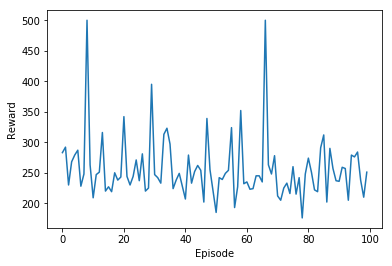

Complete
Mean:  255.59
Std:  50.840430701749504


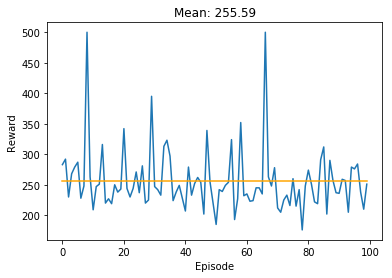

In [4]:
# define the environment
env = 'CartPole-v0'

# load weights
snn_classifier = SQN(architecture,device,alpha=ALPHA,beta=BETA,simulation_time=SIMULATION_TIME,
                             add_bias_as_observation=True,encoding=ENCODING,decoding=DECODING,
                             reset=RESET,threshold=THRESHOLD)
snn_classifier.load_state_dict(torch.load('./../../CartPole-A/SNN-Classifier/trained/model.pt'))

# load the snn classifier
load_agent(env,snn_classifier,device,epsilon=0,gym_seed=gym_seed,save_replay=False,max_steps=500,num_episodes=100, render=True)

Additionally, we can load one of the classifiers and compare it against the original network. This is demonstrated for the snn classifier in the next step, but works in the same way for the conventional classifier. This computes a similarity (or conversion accuracy) between the two networks. It is calculated by running the classifier and for each action comparing the classifiers action prediction with the DQNs action prediction. The similarity is calculated by dividing the number of equal predictions by the total amount of predictions.

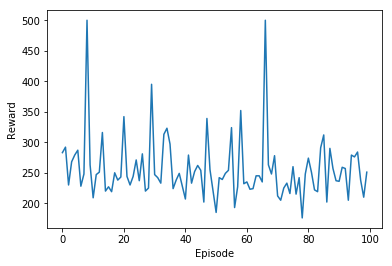

Similarity (Conversion Accuracy) after 25559 iterations: 91.12250088031612%
Complete
Mean:  255.59
Std:  50.840430701749504
Similarity (Conversion Accuracy) after 25559 iterations: 91.12250088031612%


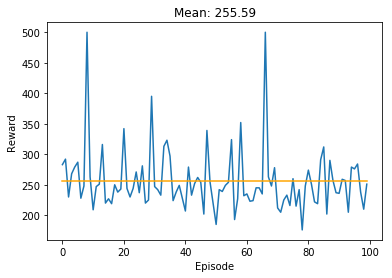

In [6]:
# load the DQN
architecture = [4, 16, 16, 2]
dqn = FullyConnected(architecture).to(device)
dqn.load_state_dict(torch.load('./../../CartPole-A/Classifier/trained/model.pt'))                                                 

# load the snn classifier and compare against the DQN
# this is equivalent to the function call before, except that we set compare_against to dqn
load_agent(env,snn_classifier,device,epsilon=0,gym_seed=gym_seed,save_replay=False,max_steps=500,num_episodes=100, render=True, compare_against=dqn)